<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/Pollardstown__3__RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import rasterio
from rasterio.enums import Resampling
from rasterio import features
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc
from scipy.ndimage import uniform_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [6]:
#open files
rgb_file = rasterio.open("/content/pollardstown_ortho.tif")
ndvi_file = rasterio.open("/content/Pollardstown_Summer_NDVI.tif")
habitat_vec = gpd.read_file("/content/Pollardstown_clappied.shp")

In [7]:
target_h, target_w = ndvi_file.height, ndvi_file.width
target_transform = ndvi_file.transform
#retrieves the raster’s pixel dimensions (height and width) and its georeferencing transform for mapping pixels to real-world coordinates

In [8]:
#aligning and texture calculation
print("Resampling and calculating texture...")
rgb_data = rgb_file.read(out_shape=(rgb_file.count, target_h, target_w), resampling=Resampling.bilinear)
ndvi_data = ndvi_file.read(1).astype('float32')
ndvi_data = np.clip(np.nan_to_num(ndvi_data, nan=0.0), -1.0, 1.0)

c1 = uniform_filter(ndvi_data, size=5)
c2 = uniform_filter(np.square(ndvi_data), size=5)
texture_data = np.sqrt(np.abs(c2 - np.square(c1)))

img_stack = np.vstack((rgb_data, ndvi_data[np.newaxis, :, :], texture_data[np.newaxis, :, :]))
n_bands = img_stack.shape[0]

# Cleanup RAM
del rgb_data, texture_data, c1, c2
gc.collect()


Resampling and calculating texture...


0

In [11]:
print("Bands:", n_bands)

Bands: 5


In [16]:
print("NDVI min/max:", ndvi_data.min(), ndvi_data.max())

NDVI min/max: -1.0 0.9010615


In [17]:

print("Rasterizing habitat polygons...")
habitat_vec = habitat_vec.to_crs(ndvi_file.crs)
shapes = ((geom, value) for geom, value in zip(habitat_vec.geometry, habitat_vec['Id']))
labeled_pixels = features.rasterize(shapes, out_shape=(target_h, target_w), transform=target_transform, fill=0)
print("Rasterization complete. Labeled pixels shape:", labeled_pixels.shape)


Rasterizing habitat polygons...
Rasterization complete. Labeled pixels shape: (12017, 17289)


In [18]:
print("Applying 3-class hierarchy...")
three_class_map = {
    2: 1, 9: 1, 10: 1, 11: 1,           # Wetland/Fen
    12: 2, 13: 2, 14: 2,                # Grassland
    15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3 # Woody/Mosaic
}
print("Hierarchy mapping defined:", three_class_map)


Applying 3-class hierarchy...
Hierarchy mapping defined: {2: 1, 9: 1, 10: 1, 11: 1, 12: 2, 13: 2, 14: 2, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3}


In [19]:

print("Flattening and sampling...")
X_all_flat = img_stack.reshape(n_bands, -1).T
y_all_flat = labeled_pixels.ravel()
print("Flattened X shape:", X_all_flat.shape, "Flattened y shape:", y_all_flat.shape)

target_samples = 3000
X_list, y_list = [], []
unique_ids = np.unique(y_all_flat[y_all_flat > 0])
print("Unique habitat IDs found:", unique_ids)

for class_id in unique_ids:
    idx = np.where(y_all_flat == class_id)[0]
    n = min(len(idx), target_samples)
    chosen = np.random.choice(idx, n, replace=False)
    X_list.append(X_all_flat[chosen])
    y_list.append(y_all_flat[chosen])
    print(f"Class {class_id}: sampled {n} pixels")

X_train_raw = np.vstack(X_list)
y_train_raw = np.concatenate(y_list)
print("Training raw data shape:", X_train_raw.shape)


Flattening and sampling...
Flattened X shape: (207761913, 5) Flattened y shape: (207761913,)
Unique habitat IDs found: [ 2  9 10 11 12 13 14 15 16 17 18 19 20]
Class 2: sampled 3000 pixels
Class 9: sampled 3000 pixels
Class 10: sampled 75 pixels
Class 11: sampled 3000 pixels
Class 12: sampled 5 pixels
Class 13: sampled 3000 pixels
Class 14: sampled 3000 pixels
Class 15: sampled 705 pixels
Class 16: sampled 3000 pixels
Class 17: sampled 3000 pixels
Class 18: sampled 3000 pixels
Class 19: sampled 3000 pixels
Class 20: sampled 3000 pixels
Training raw data shape: (30785, 5)


In [23]:

print("Applying hierarchy to training samples...")
y_final_3 = np.array([three_class_map[val] for val in y_train_raw])
print("Final 3-class labels distribution:", np.unique(y_final_3, return_counts=True))


Applying hierarchy to training samples...
Final 3-class labels distribution: (array([1, 2, 3]), array([ 9075,  6005, 15705]))


In [26]:

print("Splitting into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_final_3, test_size=0.3, stratify=y_final_3, random_state=42)
print('split')


Splitting into train/test sets...
split


In [27]:
print("Training Random Forest (1000 trees, min_node=6)...")
rf = RandomForestClassifier(
    n_estimators=1000,
    min_samples_leaf=6,
    max_features='sqrt', # This is mtry = k
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_3 = rf.predict(X_test)

Training Random Forest (1000 trees, min_node=6)...


In [28]:
target_names = ['Wetland/Fen', 'Grassland', 'Woody/Mosaic']
print("\nRefined 3-Class Report:")
print(classification_report(y_test, y_pred_3, target_names=target_names))



Refined 3-Class Report:
              precision    recall  f1-score   support

 Wetland/Fen       0.68      0.63      0.66      2723
   Grassland       0.29      0.03      0.05      1801
Woody/Mosaic       0.66      0.92      0.77      4712

    accuracy                           0.66      9236
   macro avg       0.55      0.53      0.49      9236
weighted avg       0.60      0.66      0.60      9236



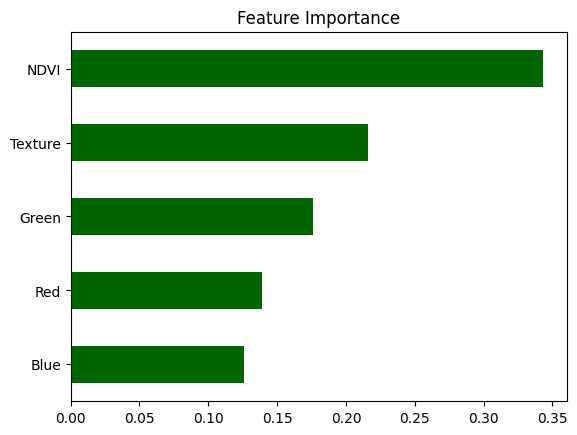

In [30]:

importances = pd.Series(rf.feature_importances_, index=['Red', 'Green', 'Blue', 'NDVI', 'Texture'])
importances.sort_values().plot(kind='barh', color='darkgreen', title="Feature Importance")
plt.show()

In [31]:
#make classes even

import numpy as np

# Current labels and features
X_train_raw = np.vstack(X_list)
y_train_raw = np.concatenate(y_list)

# Apply hierarchy mapping
y_final_3 = np.array([three_class_map[val] for val in y_train_raw])

# Find minimum class size
classes, counts = np.unique(y_final_3, return_counts=True)
min_count = counts.min()
print("Balancing classes to:", min_count, "samples each")

# Collect balanced samples
balanced_X, balanced_y = [], []
for cls in classes:
    idx = np.where(y_final_3 == cls)[0]
    chosen = np.random.choice(idx, min_count, replace=False)
    balanced_X.append(X_train_raw[chosen])
    balanced_y.append(y_final_3[chosen])

# Combine into final arrays
X_balanced = np.vstack(balanced_X)
y_balanced = np.concatenate(balanced_y)

print("Balanced dataset shape:", X_balanced.shape)



Balancing classes to: 6005 samples each
Balanced dataset shape: (18015, 5)


In [32]:

# Train/Test split after balancing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)


In [33]:

rf = RandomForestClassifier(
    n_estimators=200,        # Number of trees
    max_depth=None,          # Let trees grow fully
    random_state=42,
    n_jobs=-1                # Use all cores
)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [34]:
y_pred = rf.predict(X_test)


Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.62      0.61      1801
           2       0.41      0.38      0.40      1802
           3       0.59      0.61      0.60      1802

    accuracy                           0.54      5405
   macro avg       0.53      0.54      0.53      5405
weighted avg       0.53      0.54      0.53      5405



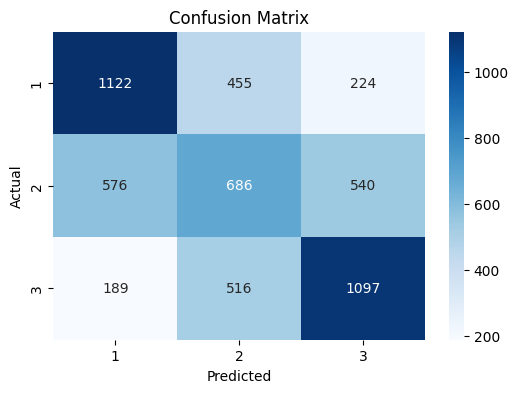

In [37]:

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.55      0.60      1801
           2       0.44      0.51      0.47      1802
           3       0.63      0.65      0.64      1802

    accuracy                           0.57      5405
   macro avg       0.58      0.57      0.57      5405
weighted avg       0.58      0.57      0.57      5405



Text(0.5, 1.0, 'Confusion Matrix')

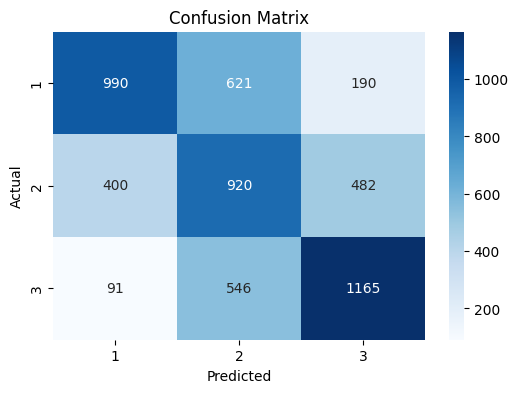

In [41]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Train/Test split (balanced dataset or original)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=1000,
    min_samples_leaf=6,
    max_features='sqrt', # This is mtry = k
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
